In [427]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.facecolor'] = (1,1,1,1)
%matplotlib inline
sns.set_style('darkgrid')
#sns.set_context("talk")
sns.set_context("notebook")

## Load data in ##

In [428]:
#June 2019 MTA data
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190629.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190622.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190615.txt')
df4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190608.txt')
june_data_raw = pd.concat([df1,df2,df3,df4], ignore_index = True)

In [429]:
#Zip codes of MTA stations
#zip_codes = pd.read_csv('https://raw.githubusercontent.com/galenballew/Metis-Submissions/master/projects/01%20Benson/data/processed/zips.csv')
#zip_codes['zip_code']=zip_codes['zip_code'].astype('str')
zip_codes=pd.read_csv('zip_codes_new.csv')
zip_codes['zip_code']=zip_codes['zip_code'].astype('str')

In [430]:
#Load in and clean income data by zip code
income_data = pd.read_csv('NY_Income_by_Zipcode.csv')
income_data = income_data.filter(['Geographic Area Name', 'Estimate!!Households!!Median income (dollars)'])
income_data.rename(columns={'Geographic Area Name' : 'zip_code','Estimate!!Households!!Median income (dollars)': 'Median income'}, inplace = True)
income_data['zip_code']=income_data['zip_code'].str.replace(r'ZCTA5 ', '')
#Fill blank values with median NYC income
income_data[income_data['zip_code']=='10020'] = '63998'
income_data[income_data['zip_code']=='10119'] = '63998'

In [431]:
#Join zip code and income data
zip_codes=zip_codes.set_index('zip_code').join(income_data.set_index('zip_code'))\
                   .reset_index().drop_duplicates(subset=['station'])
zip_codes.rename(columns = {'index': 'zipcode', 'Median income': 'zip income'},inplace=True)
zip_codes.fillna('57782', inplace=True)
zip_codes['zip income']=zip_codes['zip income'].astype('float')



In [473]:
zip_codes

,zip_code,station,zip income
0,10001,34 ST-HERALD SQ,92840.0
2,10001,36 ST,92840.0
4,10001,34 ST-PENN STA,92840.0
6,10001,34 ST-HUDSON YD,92840.0
8,10002,DELANCEY/ESSEX,36982.0
...,...,...,...
738,7114,NEWARK C,57782.0
739,7302,GROVE STREET,57782.0
740,7302,EXCHANGE PLACE,57782.0
741,7306,JOURNAL SQUARE,57782.0


## Cleaning turnstile data: ##

Fix column names by clarifying entries and exits are cumulative, add a combined datetime column, get rid of times that aren't on the hour (these seem to have weird results that throw the others off)

In [432]:
june_data_raw.rename(columns={'EXITS                                                               ':"CU_EXITS", \
                          'ENTRIES': 'CU_ENTRIES'}, inplace=True)
june_data_raw['DATETIME'] = pd.to_datetime(june_data_raw['DATE'] + ' ' + june_data_raw['TIME'])
june_data_raw = june_data_raw[(june_data_raw['DATETIME'].dt.minute==0)&(june_data_raw['DATETIME'].dt.second==0)].copy()
june_data_raw = june_data_raw[june_data_raw['STATION']!='23 ST']


## Processing ##

In [433]:
#Group the turnstile data together by datetime, not sure if this is necessary since each turnstile at each time 
#only appears once, may be able to get rid of this
june_data = (june_data_raw.groupby(["C/A", "UNIT", "SCP", "STATION", "DATE", 'TIME'],as_index=False)
            [['CU_ENTRIES','CU_EXITS']].last())

In [434]:
#Add columns for entries since the last timestep for each turnstile
june_data[['ENTRIES','EXITS']] = (june_data
                                          .groupby(["C/A", "UNIT", "SCP", "STATION"])[[ "CU_ENTRIES", 'CU_EXITS']]
                                          .apply(lambda x: x.subtract(x.shift(1))))
june_data.dropna(inplace=True)

In [435]:
#Add up turnstiles to get entries and exits for station during the specified time interval (4 hours before timestamp)
june_data = june_data.groupby(['STATION', 'DATE', 'TIME'])[['ENTRIES', 'EXITS']].sum().reset_index()

In [436]:
#More cleaning, get rid of bad values: negative or too high, 1 million people shouldnt pass through station
#in 4 hours
mask = ((june_data['ENTRIES'] >= 0) & \
        (june_data['EXITS'] >= 0) & \
        (june_data['ENTRIES'] < 1e6) & \
        (june_data['EXITS'] < 1e6))
june_data = june_data[mask].copy()

In [437]:
#Make total ridership column
june_data['TOTAL RIDERSHIP'] = june_data['ENTRIES']+june_data['EXITS']

In [438]:
june_data['DAYOFWEEK'] = pd.to_datetime(june_data['DATE']).dt.dayofweek

In [439]:
june_data = june_data.set_index('STATION').join(zip_codes.set_index('station')).reset_index()
june_data.rename(columns = {'index': 'STATION'},inplace=True)
june_data

,STATION,DATE,TIME,ENTRIES,EXITS,TOTAL RIDERSHIP,DAYOFWEEK,zip_code,zip income
0,1 AV,06/01/2019,04:00:00,643.0,627.0,1270.0,5,10009,63717.0
1,1 AV,06/01/2019,08:00:00,182.0,609.0,791.0,5,10009,63717.0
2,1 AV,06/01/2019,12:00:00,776.0,1697.0,2473.0,5,10009,63717.0
3,1 AV,06/01/2019,16:00:00,1933.0,2325.0,4258.0,5,10009,63717.0
4,1 AV,06/01/2019,20:00:00,1883.0,2443.0,4326.0,5,10009,63717.0
...,...,...,...,...,...,...,...,...,...
65360,ZEREGA AV,06/28/2019,05:00:00,66.0,103.0,169.0,4,10461,58305.0
65361,ZEREGA AV,06/28/2019,09:00:00,894.0,408.0,1302.0,4,10461,58305.0
65362,ZEREGA AV,06/28/2019,13:00:00,520.0,292.0,812.0,4,10461,58305.0
65363,ZEREGA AV,06/28/2019,17:00:00,611.0,543.0,1154.0,4,10461,58305.0


In [440]:
june_data['WEIGHTED RIDERSHIP'] = june_data['TOTAL RIDERSHIP'] * june_data['zip income']/63998

In [441]:
june_data

,STATION,DATE,TIME,ENTRIES,EXITS,TOTAL RIDERSHIP,DAYOFWEEK,zip_code,zip income,WEIGHTED RIDERSHIP
0,1 AV,06/01/2019,04:00:00,643.0,627.0,1270.0,5,10009,63717.0,1264.423732
1,1 AV,06/01/2019,08:00:00,182.0,609.0,791.0,5,10009,63717.0,787.526907
2,1 AV,06/01/2019,12:00:00,776.0,1697.0,2473.0,5,10009,63717.0,2462.141645
3,1 AV,06/01/2019,16:00:00,1933.0,2325.0,4258.0,5,10009,63717.0,4239.304135
4,1 AV,06/01/2019,20:00:00,1883.0,2443.0,4326.0,5,10009,63717.0,4307.005563
...,...,...,...,...,...,...,...,...,...,...
65360,ZEREGA AV,06/28/2019,05:00:00,66.0,103.0,169.0,4,10461,58305.0,153.966452
65361,ZEREGA AV,06/28/2019,09:00:00,894.0,408.0,1302.0,4,10461,58305.0,1186.179412
65362,ZEREGA AV,06/28/2019,13:00:00,520.0,292.0,812.0,4,10461,58305.0,739.767805
65363,ZEREGA AV,06/28/2019,17:00:00,611.0,543.0,1154.0,4,10461,58305.0,1051.344886


## From here we can split off the data into various forms that we want to look at ##

**Daily ridership data for each station**

In [442]:
june_data_daily = june_data.groupby(['STATION', 'DATE','DAYOFWEEK', 'zip income'])[['TOTAL RIDERSHIP', 'WEIGHTED RIDERSHIP']].sum().reset_index()

In [443]:
june_data_daily.sort_values('TOTAL RIDERSHIP',ascending=False)

,STATION,DATE,DAYOFWEEK,zip income,TOTAL RIDERSHIP,WEIGHTED RIDERSHIP
5072,CLINTON-WASH AV,06/13/2019,3,91846.0,870383.0,1.249120e+06
1596,34 ST-PENN STA,06/28/2019,4,92840.0,340625.0,4.941346e+05
1586,34 ST-PENN STA,06/18/2019,1,92840.0,339260.0,4.921544e+05
1581,34 ST-PENN STA,06/13/2019,3,92840.0,336974.0,4.888382e+05
1588,34 ST-PENN STA,06/20/2019,3,92840.0,335476.0,4.866651e+05
...,...,...,...,...,...,...
8150,ORCHARD BEACH,06/11/2019,1,96366.0,0.0,0.000000e+00
8149,ORCHARD BEACH,06/10/2019,0,96366.0,0.0,0.000000e+00
1269,25 AV,06/09/2019,6,56911.0,0.0,0.000000e+00
940,191 ST,06/16/2019,6,49677.0,0.0,0.000000e+00


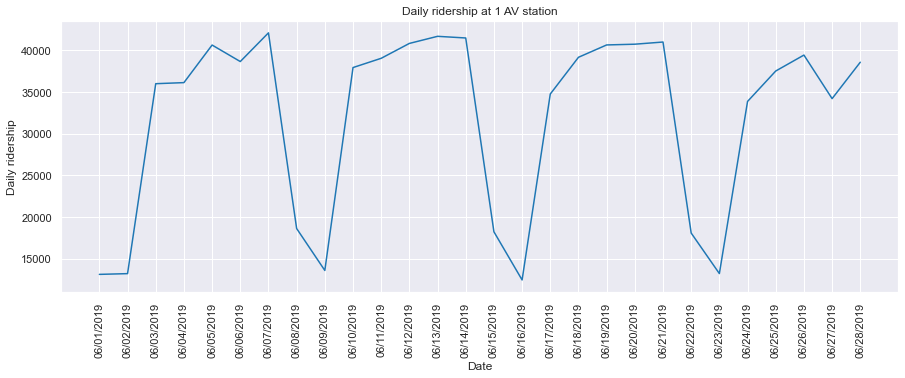

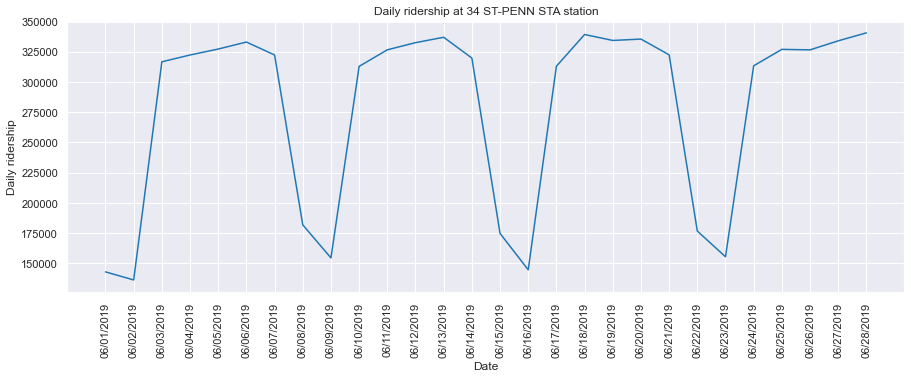

In [444]:
#Function for plotting monthly time series of stop
def plot_monthly_series(df, station):
    station_df = df.loc[df['STATION'] == station].copy()
    plt.figure(figsize = (15,5))
    plt.plot(station_df['DATE'], station_df['TOTAL RIDERSHIP'])
    plt.xticks(rotation = 'vertical')
    plt.xlabel('Date')
    plt.ylabel('Daily ridership')
    plt.title('Daily ridership at ' + station + ' station')
    plt.show()
plot_monthly_series(june_data_daily, '1 AV')
plot_monthly_series(june_data_daily, '34 ST-PENN STA')

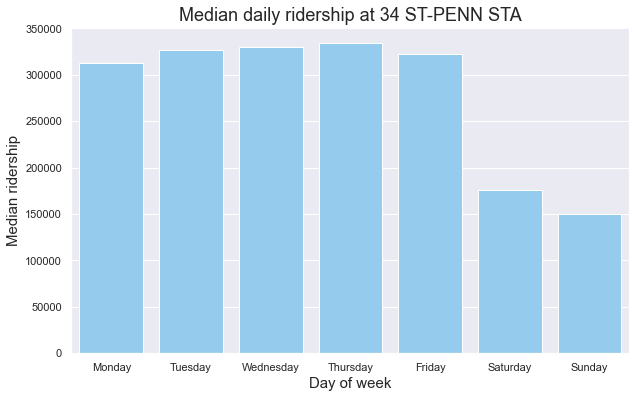

In [446]:
days = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
#Function for plotting median ridership at a station 
def plot_daily(df, station, save = False):
    plt.figure(figsize=(10,6))
    station_df = df.loc[df['STATION'] == station].copy()
    median_ridership = station_df.groupby(['DAYOFWEEK'])['TOTAL RIDERSHIP'].median()
    ax=sns.barplot(x = days, y = median_ridership, color = 'LightSkyBlue')
    plt.xlabel('Day of week', fontsize = 15) 
    plt.ylabel('Median ridership', fontsize = 15) 
    plt.title('Median daily ridership at '+ station, fontsize=18)
    plt.xticks(rotation = 0)
    if save: plt.savefig('data/'+station+'_daily.png')
plot_daily(june_data_daily, '34 ST-PENN STA')

## Hourly data ##

In [449]:
june_data_hourly = june_data.groupby(['STATION', 'TIME','DAYOFWEEK'])[['TOTAL RIDERSHIP', 'WEIGHTED RIDERSHIP']].median().reset_index()

In [450]:
june_data_hourly

,STATION,TIME,DAYOFWEEK,TOTAL RIDERSHIP,WEIGHTED RIDERSHIP
0,1 AV,00:00:00,0,2189.5,2179.886426
1,1 AV,00:00:00,1,3938.0,3920.709178
2,1 AV,00:00:00,2,4748.5,4727.650466
3,1 AV,00:00:00,3,4868.5,4847.123574
4,1 AV,00:00:00,4,5180.0,5157.255852
...,...,...,...,...,...
16503,ZEREGA AV,21:00:00,2,1191.0,1085.053517
16504,ZEREGA AV,21:00:00,3,1138.5,1037.223702
16505,ZEREGA AV,21:00:00,4,1092.0,994.860152
16506,ZEREGA AV,21:00:00,5,577.0,525.672443


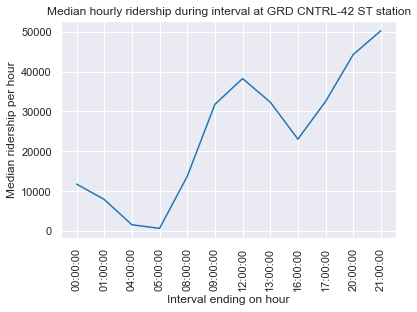

In [452]:
#Plot median 4-hourly traffic at station
def plot_hourly(df, station, weekday_only = True):
    station_df = df.loc[df['STATION'] == station].copy()
    if weekday_only:
        station_df = station_df[station_df['DAYOFWEEK']<=4] #0-4 = monday to friday
    median_ridership = station_df.groupby(['TIME'])['TOTAL RIDERSHIP'].median()
    #plt.plot(median_ridership.index, median_ridership)
    sns.lineplot(x=median_ridership.index, y=median_ridership)
    plt.xticks(rotation='vertical')
    plt.xlabel('Interval ending on hour')
    plt.ylabel('Median ridership per hour')
    plt.title('Median hourly ridership during interval at ' + station + ' station')
    plt.show()
plot_hourly(june_data_hourly, 'GRD CNTRL-42 ST')

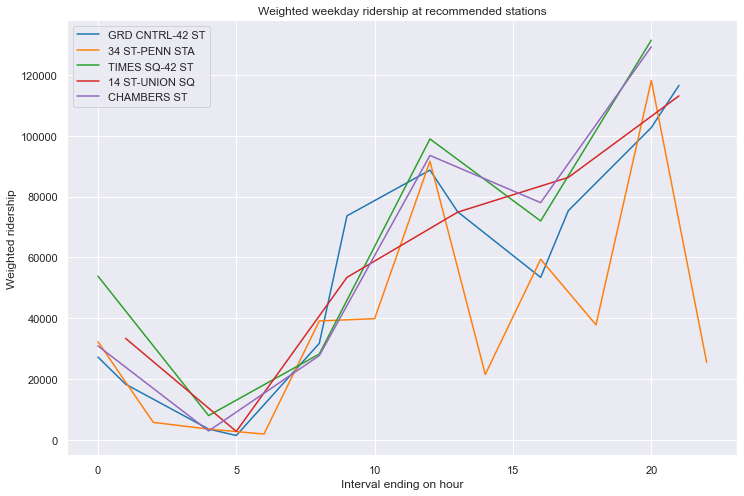

In [453]:
def plot_hourly_multiple(df, stations, ride_type, title, ylabel, weekday_only = True, save = False):
    plt.figure(figsize=(12,8))
    for station in stations:
        station_df = df.loc[df['STATION'] == station].copy()
        if weekday_only:
            station_df = station_df[station_df['DAYOFWEEK']<=4] #0-4 = monday to friday
        median_ridership = station_df.groupby(['TIME'])[ride_type].median()
        #plt.plot(pd.to_datetime(median_ridership.index).hour, median_ridership, label = str(station))
        sns.lineplot(x=pd.to_datetime(median_ridership.index).hour, y=median_ridership,label = str(station))
        plt.xlabel('Interval ending on hour')
        plt.ylabel(ylabel)
        plt.legend()
        plt.title(title)
    if save: plt.savefig('pics/'+title+'.png')
    plt.show()
plot_hourly_multiple(june_data_hourly, top_median_stations_weighted[:5],'WEIGHTED RIDERSHIP',
                    'Weighted weekday ridership at recommended stations', 'Weighted ridership', save = True)

In [454]:
def plot_hourly_series(df, stations, ride_type, title, ylabel, weekday_only = True, save = False):
    for station in stations:
        plt.figure(figsize=(10,6))
        station_df = df.loc[df['STATION'] == station].copy()
        if weekday_only:
            station_df = station_df[station_df['DAYOFWEEK']<=4] #0-4 = monday to friday
        median_ridership = station_df.groupby(['TIME'])[ride_type].median()
        #plt.plot(pd.to_datetime(median_ridership.index).hour, median_ridership, linewidth=3)
        xax=pd.to_datetime(median_ridership.index).hour
        sns.lineplot(x=xax, y=median_ridership, linewidth=4)
        plt.xlabel('Time', fontsize=15)
        plt.ylabel(ylabel, fontsize=15)
        plt.xticks(np.arange(0,24,4))
        plt.title(title+' at '+ station+ ' station', fontsize = 18)
        if save: plt.savefig('pics/'+station+ '_hourly'+'.png')
        plt.show()


**Summary statistics for ridership across the whole month, indexed by station**

In [475]:
june_data_station_stats = june_data_daily.groupby(['STATION','zip income'])['TOTAL RIDERSHIP']\
                            .agg([('MEAN', 'mean'),('MEDIAN', 'median'),('SUM', 'sum')])\
                            .reset_index().sort_values('MEDIAN', ascending = False)
june_data_station_stats_weighted = june_data_daily.groupby(['STATION','zip income'])['WEIGHTED RIDERSHIP']\
                            .agg([('MEAN', 'mean'),('MEDIAN', 'median'),('SUM', 'sum')])\
                            .reset_index().sort_values('MEDIAN', ascending = False)
weekday_mask = june_data_daily['DAYOFWEEK'] <= 4
june_data_station_weekday_stats = june_data_daily[weekday_mask].groupby(['STATION','zip income'])['TOTAL RIDERSHIP']\
                                 .agg([('MEAN', 'mean'),('MEDIAN', 'median'),('SUM', 'sum')])\
                                 .reset_index().sort_values('MEDIAN', ascending = False)
june_data_station_weekday_stats_weighted = june_data_daily[weekday_mask].groupby(['STATION','zip income'])['WEIGHTED RIDERSHIP']\
                                 .agg([('MEAN', 'mean'),('MEDIAN', 'median'),('SUM', 'sum')])\
                                 .reset_index().sort_values('MEDIAN', ascending = False)

In [486]:
tfm=june_data_station_weekday_stats[june_data_station_weekday_stats['STATION'].isin(top_median_stations_weighted[:10])].copy()
tfm.drop(columns = ['MEAN', 'SUM'],inplace=True)
tfm['Weighted ridership'] = tfm['MEDIAN'] * tfm['zip income']/63998
tfm.rename(columns = {'STATION': 'Station','zip income': 'Zipcode income', 'MEDIAN':'Median daily ridership'}, inplace =True)
tfm = tfm [['Station','Median daily ridership', 'Zipcode income', 'Weighted ridership']].sort_values('Weighted ridership', ascending=False)
tfm

,Station,Median daily ridership,Zipcode income,Weighted ridership
224,GRD CNTRL-42 ST,288026.0,148441.0,668065.681209
56,34 ST-PENN STA,326781.5,92840.0,474052.227570
331,TIMES SQ-42 ST,199327.0,122484.0,381486.425638
14,14 ST-UNION SQ,196682.0,118161.0,363138.563736
173,CHAMBERS ST,102256.0,224063.0,358007.845995
105,86 ST,150998.0,143623.0,338866.616988
54,34 ST-HERALD SQ,231170.0,92840.0,335351.460983
217,FULTON ST,192184.5,95702.0,287390.871887
81,59 ST COLUMBUS,129910.0,132605.0,269175.842214
80,59 ST,114478.5,148441.0,265528.657435


In [413]:
def plot_ridership_bar(stats_df, station_list, metric, title, ylabel, show_income = False, save=False):
    stations_df = stats_df[stats_df['STATION'].isin(station_list)][['STATION','zip income',metric]]
    stations_df.sort_values(metric, ascending = False, inplace=True)
    stations = stations_df['STATION']
    station_metrics = stations_df[metric]
    station_incomes = stations_df['zip income']
    
    if show_income:
        plt.figure(figsize=(15,6))

        norm = plt.Normalize(station_incomes.min(), station_incomes.max())
        sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm) #or magma
        sm.set_array([])
        
        ax = sns.barplot(x=stations, y=station_metrics, hue=station_incomes, palette='Blues', dodge=False)
        
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Station')
        ax.get_legend().remove()
        cb=ax.figure.colorbar(sm)
        cb.set_label('Median income of station zipcode ($)')
        plt.xticks(rotation=75)
        plt.title(title, fontsize='20')
        if save: plt.savefig('pics/'+title+'.png')
        plt.show()
        
    else:
        plt.figure(figsize=(12,6))

        ax = sns.barplot(x=stations, y=station_metrics, color='LightSkyBlue', dodge=False)
        
        ax.set_ylabel(ylabel)
        ax.set_xlabel('Station')
        plt.xticks(rotation=75)
        plt.title(title, fontsize='20')
        if save: plt.savefig('pics/'+title+'.png')
        plt.show()

def plot_income_bar(stats_df, station_list, title):
    stations_df = stats_df[stats_df['STATION'].isin(station_list)][['STATION','zip income']]
    stations_df.sort_values('zip income', ascending = False, inplace=True)
    stations = stations_df['STATION']
    station_incomes = stations_df['zip income']
    
    plt.figure(figsize=(12,6))
    sns.barplot(x=stations, y = station_incomes, palette = 'magma', dodge = False)
    plt.xlabel('Station')
    plt.xticks(rotation=90)
    plt.ylabel('Median income of station zipcode ($)')
    plt.title(title)
    plt.show()

In [414]:
#plot_ridership_bar(june_data_station_weekday_stats, top_median_stations[:20], 'MEDIAN', 'Weekday only median ridership', show_income = True)
#plot_ridership_bar(june_data_station_stats, top_median_stations[:20], 'MEDIAN', 'All days median ridership', show_income = True)
#plot_income_bar(june_data_station_stats, top_income_stations[:20], 'Top income stations')


## Generate plots used in presentation ##

In [487]:
top_income_stations = june_data_station_stats.sort_values('zip income', ascending = False)['STATION']

top_median_stations = june_data_station_stats.sort_values('MEDIAN', ascending = False)['STATION']
top_sum_stations    = june_data_station_stats.sort_values('SUM', ascending = False)['STATION']

top_median_stations_weighted = june_data_station_stats_weighted.sort_values('MEDIAN', ascending = False)['STATION']
top_sum_stations_weighted    = june_data_station_stats_weighted.sort_values('SUM', ascending = False)['STATION']
#wd = weighted weekday
top_median_stations_wd = june_data_station_weekday_stats.sort_values('MEDIAN', ascending = False)['STATION']
top_sum_stations_wd    = june_data_station_weekday_stats.sort_values('SUM', ascending = False)['STATION']

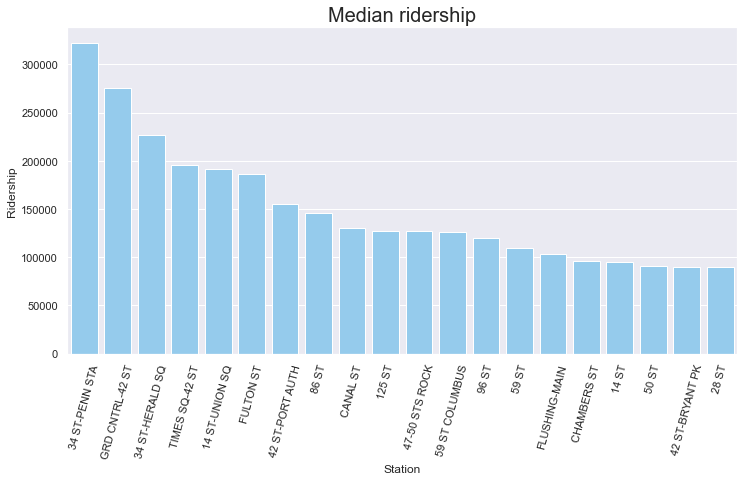

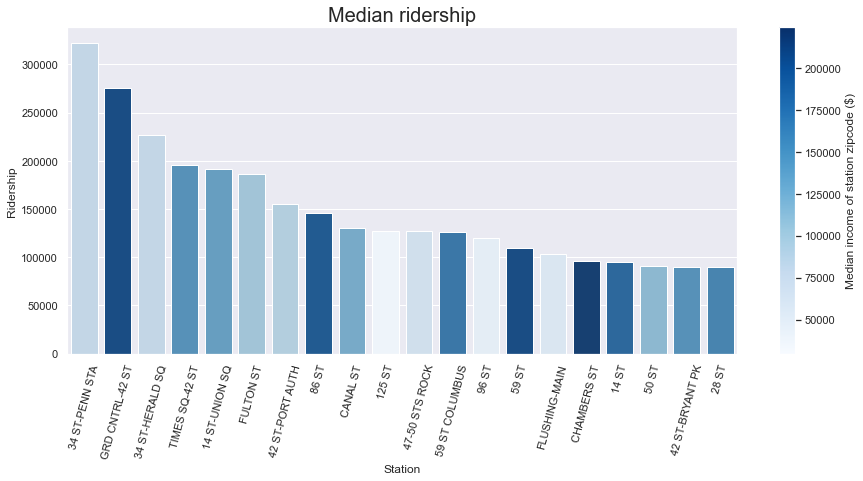

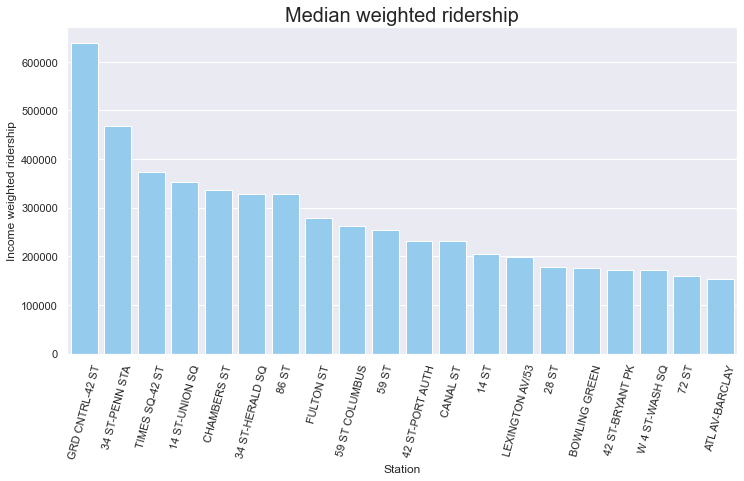

In [488]:
plot_ridership_bar(june_data_station_stats, top_median_stations[:20],
                    'MEDIAN', 'Median ridership', 'Ridership', show_income = False, save=False)
plot_ridership_bar(june_data_station_stats, top_median_stations[:20],
                    'MEDIAN', 'Median ridership', 'Ridership', show_income = True, save=False)
plot_ridership_bar(june_data_station_stats_weighted, top_median_stations_weighted[:20],
                    'MEDIAN', 'Median weighted ridership', 'Income weighted ridership', show_income = False, save=False)


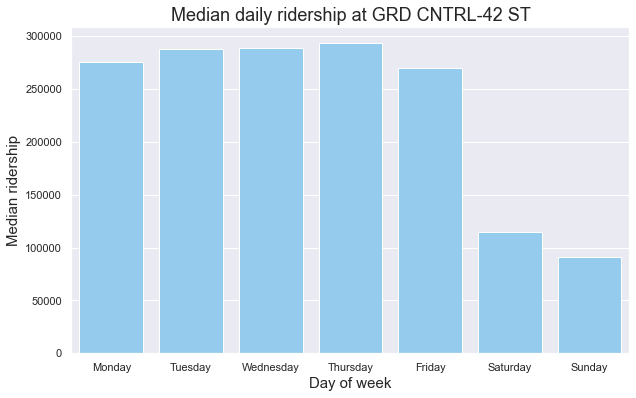

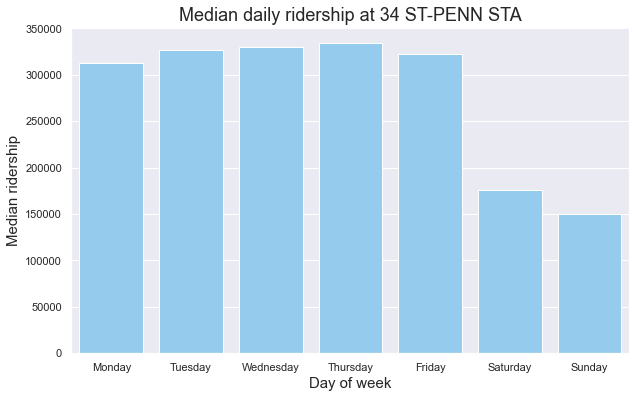

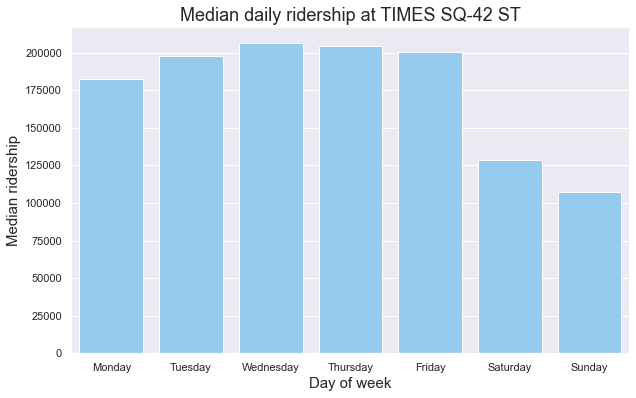

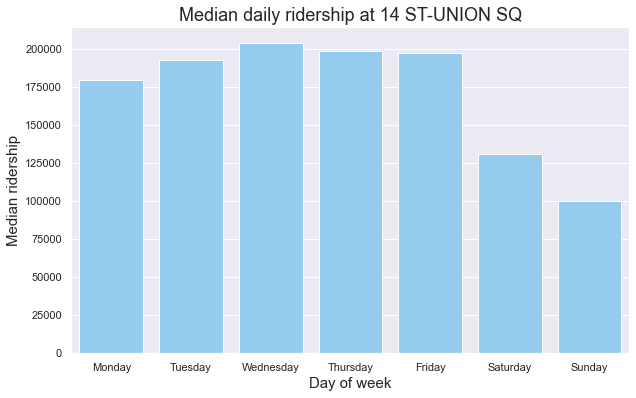

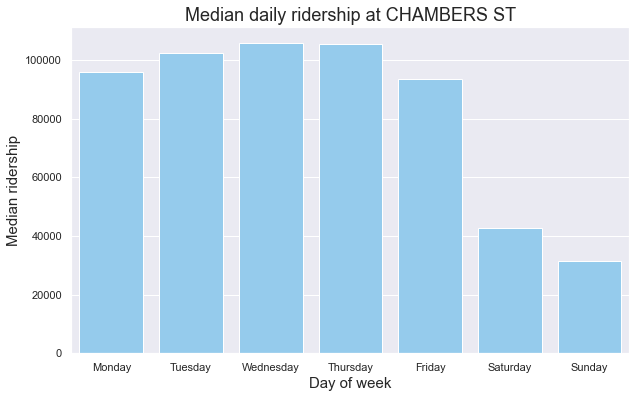

In [489]:
for station in top_median_stations_weighted[:5]:
    plot_daily(june_data_daily, station,save=False)

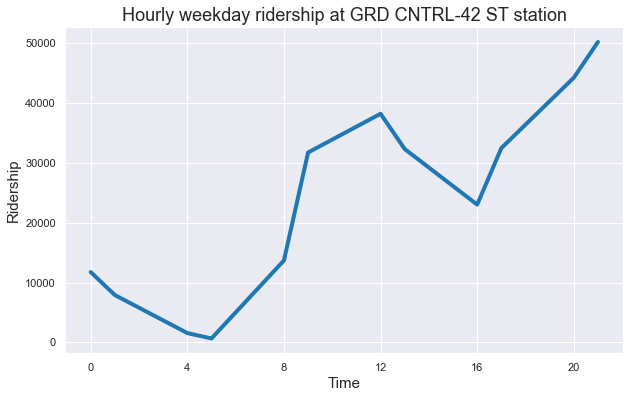

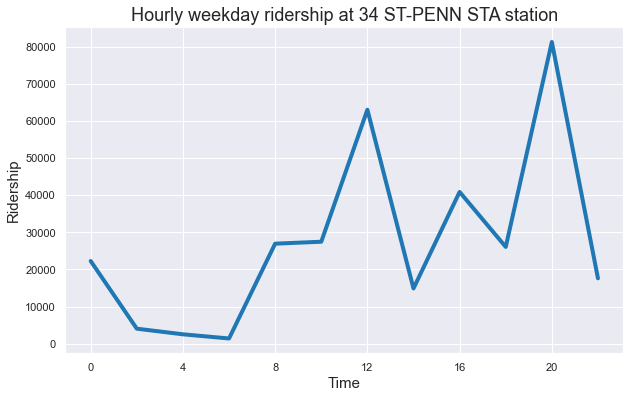

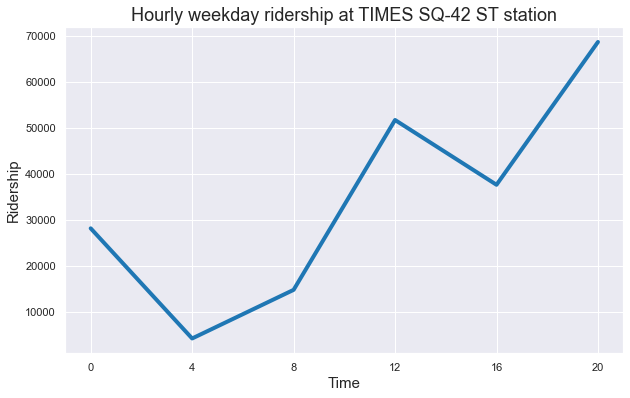

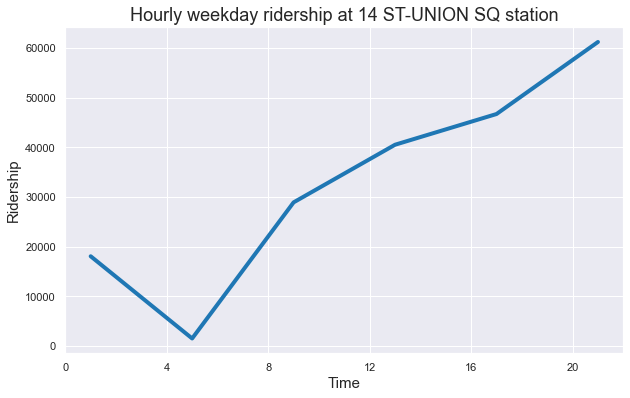

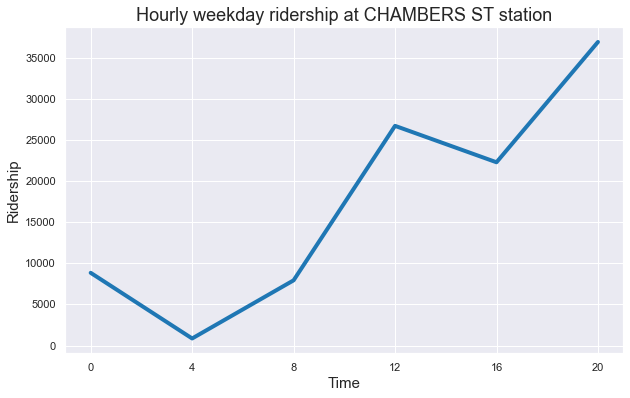

In [490]:
plot_hourly_series(june_data_hourly, top_median_stations_weighted[:5],'TOTAL RIDERSHIP',
                    'Hourly weekday ridership', 'Ridership',weekday_only=True, save = False)